# Trump For Stock Prediction
### Predicting Stock Prices from the Sentiment of Donald model_data's Tweets
Adam Haile, Alhagie Boye, Eric Van Zant

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates
from scipy.stats import linregress
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from tqdm import tqdm

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/vanzante/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### **Research Question**

Does the sentiment of Donald model_data's tweets from 2010 to 2021 correlate with the fluctuations in the S&P 500 stock index during the same period?

### Objectives
1. Obtain the sentiment of Trump’s tweets utilizing TextBlob. 
2. Correlate the sentiment of Trump’s tweets to the fluctuation of stock. 
3. Develop a model capable of predicting stock prices based on Trump’s tweets.

### **Hypothesis**

**Null Hypothesis:** There is no correlation between the sentiment of Trump’s tweets and the S&P 500 stock price.  

**Alternative Hypothesis:** There is a correlation between the sentiment of Trump’s tweets and the S&P 500 stock price.    

### **Dataset**

* **Trumps Legacy Dataset**: https://www.kaggle.com/datasets/zusmani/trumps-legacy
* **SP500 Dataset**: https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks/
* **SP500 Companies**: https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks/?select=sp500_companies.csv

**Trump's Legacy**

* This dataset contains 56,571 tweets from Donald Trump's Twitter account. The dataset was collected from the Trump Twitter Archive. The dataset contains the following columns: id, date, time, source, text, retweets, favorites, is_retweet, and id_str. The dataset was collected from January 20, 2017, to January 8, 2021.

In [10]:
trump = pd.read_csv('trump_legacy/Trumps Legcy.csv')
trump.head()

id                                               text  \
0  9.845500e+16  Republicans and Democrats have both created ou...   
1  1.234650e+18  I was thrilled to be back in the Great city of...   
2  1.218010e+18  RT @CBS_Herridge: READ: Letter to surveillance...   
3  1.304880e+18  The Unsolicited Mail In Ballot Scam is a major...   
4  1.218160e+18  RT @MZHemingway: Very friendly telling of even...   

               device  favorites  retweets             date  
0           TweetDeck         49       255   8/2/2011 18:07  
1  Twitter for iPhone      73748     17404    3/3/2020 1:34  
2  Twitter for iPhone          0      7396   1/17/2020 3:22  
3  Twitter for iPhone      80527     23502  9/12/2020 20:10  
4  Twitter for iPhone          0      9081  1/17/2020 13:13

**SP500 Stocks**

* This dataset contains the daily closing price of the S&P 500 index from January 20, 2017, to January 8, 2021. The dataset contains the following columns: date, close, high, low, open, and volume.

In [11]:
stock = pd.read_csv('sp500_daily/sp500_stocks.csv')
stock.head()

Date Symbol  Adj Close      Close       High        Low       Open  \
0  2010-01-04    MMM  53.295406  83.019997  83.449997  82.669998  83.089996   
1  2010-01-05    MMM  52.961571  82.500000  83.230003  81.699997  82.800003   
2  2010-01-06    MMM  53.712673  83.669998  84.599998  83.510002  83.879997   
3  2010-01-07    MMM  53.751186  83.730003  83.760002  82.120003  83.320000   
4  2010-01-08    MMM  54.129955  84.320000  84.320000  83.300003  83.690002   

      Volume  
0  3043700.0  
1  2847000.0  
2  5268500.0  
3  4470100.0  
4  3405800.0

**SP500 Companies**

* This dataset contains the list of companies in the S&P 500 index. The dataset contains the following columns: Symbol, Security, SEC filings, GICS Sector, GICS Sub-Industry, Headquarters Location, Date first added, CIK, Founded. It contains 505 rows and 9 columns.

In [12]:
spCompanies = pd.read_csv('sp500_daily/sp500_companies.csv')
spCompanies.head()

Exchange Symbol              Shortname               Longname  \
0      NMS   MSFT  Microsoft Corporation  Microsoft Corporation   
1      NMS   AAPL             Apple Inc.             Apple Inc.   
2      NMS   NVDA     NVIDIA Corporation     NVIDIA Corporation   
3      NMS   AMZN       Amazon.com, Inc.       Amazon.com, Inc.   
4      NMS  GOOGL          Alphabet Inc.          Alphabet Inc.   

                   Sector                        Industry  Currentprice  \
0              Technology       Software - Infrastructure        407.72   
1              Technology            Consumer Electronics        181.42   
2              Technology                  Semiconductors        776.63   
3       Consumer Cyclical                 Internet Retail        173.16   
4  Communication Services  Internet Content & Information        136.38   

       Marketcap        Ebitda  Revenuegrowth           City State  \
0  3029538963456  1.184270e+11          0.176        Redmond    WA   
1  2801469489152  1.301090e+11          0.021      Cupertino    CA   
2  1941575041024  3.448000e+10          2.653    Santa Clara    CA   
3  1798682181632  8.551500e+10          0.139        Seattle    WA   
4  1702349766656  1.001720e+11          0.135  Mountain View    CA   

         Country  Fulltimeemployees  \
0  United States           221000.0   
1  United States           161000.0   
2  United States            29600.0   
3  United States          1525000.0   
4  United States           182502.0   

                                 Longbusinesssummary    Weight  
0  Microsoft Corporation develops and supports so...  0.064540  
1  Apple Inc. designs, manufactures, and markets ...  0.059681  
2  NVIDIA Corporation provides graphics, and comp...  0.041363  
3  Amazon.com, Inc. engages in the retail sale of...  0.038318  
4  Alphabet Inc. offers various products and plat...  0.036266

### **Data Preprocessing**

The only data preprocessing needed for the stock data was to just sort by date rather than symbol. Other than this, the data is already decently well organized and maintained.

In [13]:
stock['Date'] = pd.to_datetime(stock['Date'])
stock = stock.sort_values('Date')

Data preprocessing for the Trump data occurred in a few steps. The first segment was processing the Trump data for sentiment analysis. This required first sorting the data based upon date (as it was not already sorted by this), to ensure it would be easier to work with down the line. From here, some NLP is applied to remove all links in the tweet text, and removing the word 'RT'. This is done for a few reasons:
- When sentiment analysis is applied on the tweet data with links, they tend to be inflated towards neutral, so removing links within text, or dropping rows of data which are exclusively just links, can reduce this inflation by about 2%

In [14]:
trump['date'] = pd.to_datetime(trump['date'])
trump = trump.sort_values('date')

def is_only_link(text):
    text = text.strip()
    return text.startswith('http://') or text.startswith('https://') and ' ' not in text

# Remove rows where text is only a link
link_filtered = trump[~trump['text'].apply(is_only_link)]

# Remove all links entirely
def remove_links(text):
    return ' '.join([word for word in text.split() if not is_only_link(word)])

- The letters 'RT' also tend to be treated as neutral, so there can be some bias in the tweet by leaving these. The goal is to classify the sentiment, so even if a tweet is a retweet, it is still important to keep as it indicates the sentiment of Trump at the time, so we can get more accurate results by removing 'RT', and reduces the neutrality inflation by about 3%.

In [15]:
# Remove rows where text is a retweet
retweet_filtered = link_filtered[~link_filtered['text'].str.startswith('RT')]

trump['text'] = retweet_filtered['text'].apply(remove_links)
trump.dropna(subset=['text'], inplace=True)

Now that the Trump data has been preprocessed, we can begin to perform Sentiment Analysis on the tweet text.

### **Data Analysis and Visualization**

#### Stock Data Analysis
Stock data and market data analysis
  
A list of the symbols of the top 10 stocks with the highest market cap

In [16]:
top_10 = spCompanies.nlargest(10, 'Marketcap')['Symbol'].tolist()
print(top_10)

['MSFT', 'AAPL', 'NVDA', 'AMZN', 'GOOGL', 'GOOG', 'META', 'BRK-B', 'LLY', 'TSLA']


**Stock data analysis - Pie Chart of Top 10 Stocks**

* In this analysis top 10 stocks in the S&P 500 index based on their closing prices.
* The closing price is use because it reflects the final valuation of a stock at the end of a trading day. It serves as the primary benchmark to assess if the stock has gained or lost value compared to the previous day's close.
* We will plot a pie chart to visualize the composition of the stocks.

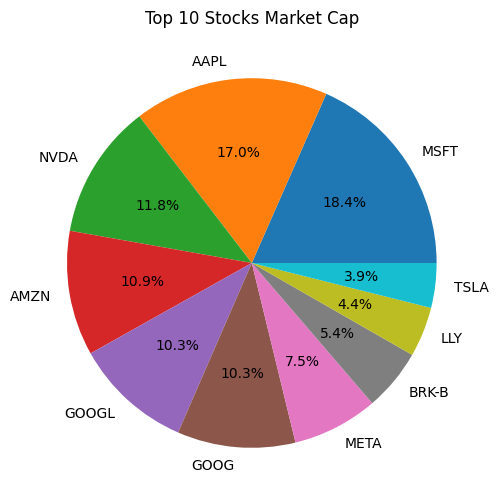

In [17]:
top_10_market_cap = spCompanies.nlargest(10, 'Marketcap')['Marketcap'].tolist()
top_10_stocks = spCompanies.nlargest(10, 'Marketcap')['Symbol'].tolist()

plt.figure(figsize=(12, 6))
plt.pie(top_10_market_cap, labels=top_10_stocks, autopct='%1.1f%%')
plt.title('Top 10 Stocks Market Cap')
plt.show()

**Line Chart of Top 10 Stocks**

* We will plot a line chart to visualize the closing prices of the top 10 stocks in the S&P 500 index.
* The line chart will show the trend of the closing prices over time.
* It provide a straightforward ways to visualize price movements over time.
* The line chart will also show the volume of stock traded over time.



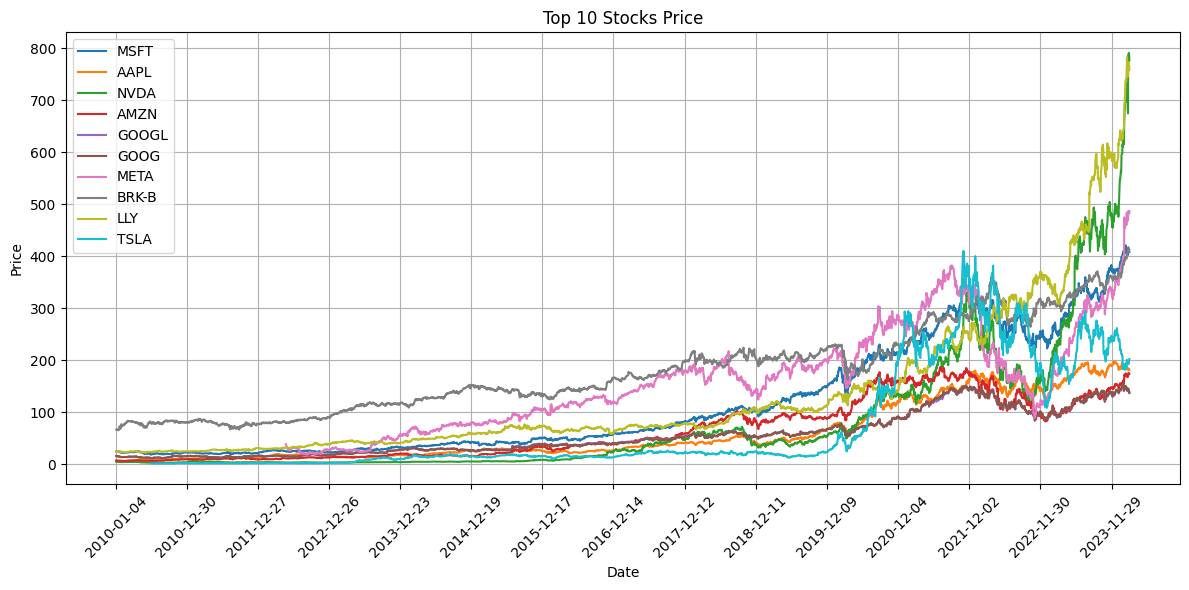

In [18]:
plt.figure(figsize=(12, 6))
for company in top_10:
    stock_data = stock[stock['Symbol'] == company]
    plt.plot(stock_data['Date'], stock_data['Adj Close'], label=company)  

plt.title('Top 10 Stocks Price')
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(stock_data['Date'][::250], rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Stock Company Analysis - Top 10 Industries**

* We will analyze the top 10 industries in the S&P 500 index based on the number of companies in each industry.
* The analysis will also consider the total market capitalization of the companies within each industry. This will provide a more comprehensive view of the industry's size and influence in the market.
* We will visualize this data using a pie chart, which will allow us to easily compare the industries.

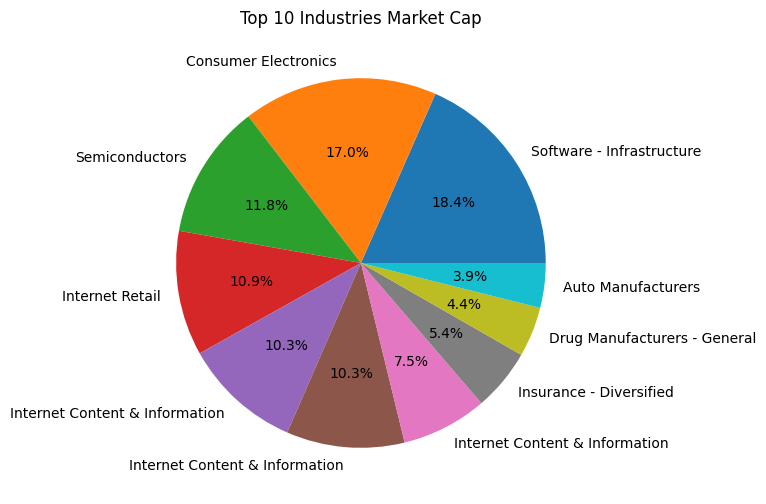

In [19]:
top_10_Insustries = spCompanies.nlargest(10, 'Marketcap')['Industry'].tolist()

plt.figure(figsize=(12, 6))
plt.pie(top_10_market_cap, labels=top_10_Insustries, autopct='%1.1f%%')
plt.title('Top 10 Industries Market Cap')
plt.show()

**A bar chart of the average stock prices of the top 10 stocks with the highest market cap**

In this analysis, we will be examining the top 10 stocks with the highest market capitalization.
We will calculate the average 'Open', 'High', 'Low', and 'Close' prices for each of these stocks.
These average prices will be visualized using a bar chart, which will allow us to easily compare the stocks. Each stock will have four bars - one for each type of price.
The 'Open' price is the price at which the stock first traded when the market opened, the 'High' price is the highest price at which the stock traded during the day, the 'Low' price is the lowest price at which the stock traded during the day, and the 'Close' price is the price at which the stock last traded when the market closed.


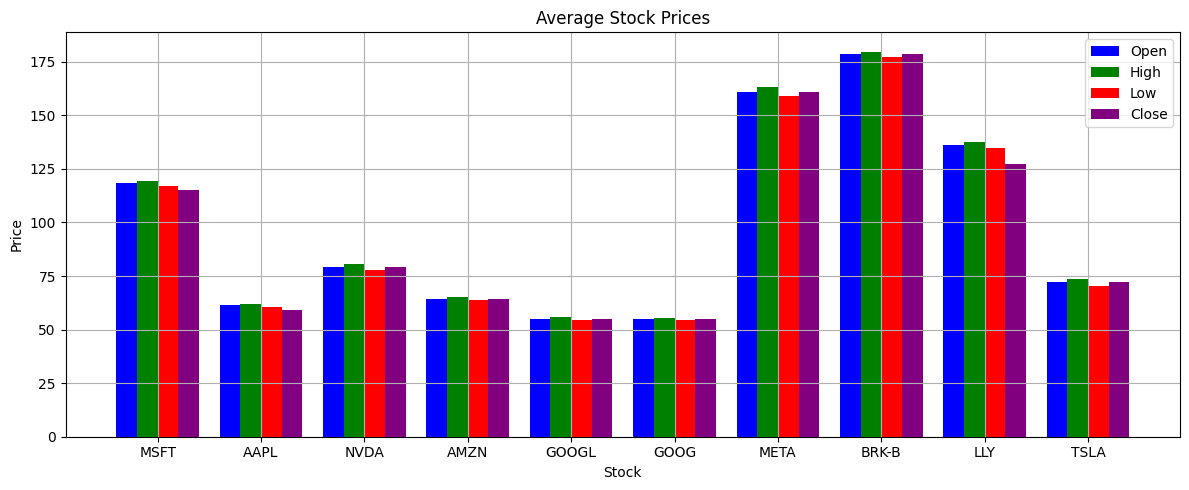

In [20]:
n = len(top_10)
x = np.arange(n)
width = 0.2

# colors for each type of price
colors = {'Open': 'blue', 'High': 'green', 'Low': 'red', 'Close': 'purple'}

plt.figure(figsize=(12, 5))

# For each stock, create a bar for 'Open', 'High', 'Low', and 'Close' prices
for i, company in enumerate(top_10):
    stock_data = stock[stock['Symbol'] == company]
    avg_open = stock_data['Open'].mean()
    avg_high = stock_data['High'].mean()
    avg_low = stock_data['Low'].mean()
    avg_close = stock_data['Adj Close'].mean()

    plt.bar(x[i] - width*1.5, avg_open, width, color=colors['Open'], label='Open' if i == 0 else "")
    plt.bar(x[i] - width/2, avg_high, width, color=colors['High'], label='High' if i == 0 else "")
    plt.bar(x[i] + width/2, avg_low, width, color=colors['Low'], label='Low' if i == 0 else "")
    plt.bar(x[i] + width*1.5, avg_close, width, color=colors['Close'], label='Close' if i == 0 else "")


plt.title('Average Stock Prices')
plt.xlabel("Stock")
plt.ylabel("Price")
plt.xticks(x, top_10)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**STOCK PRICES(HIGH, LOW, OPEINING, ADJ CLOSING) OF EACH OF THE TOP 10 COMPANIES**

This analysis will be done by plotting a line chart of the stock prices of the top 10 companies in the S&P 500 index. The line chart will show the high, low, opening, and adjusted closing prices of each company over time. This will allow us to visualize the price movements of each company and compare them to each other.

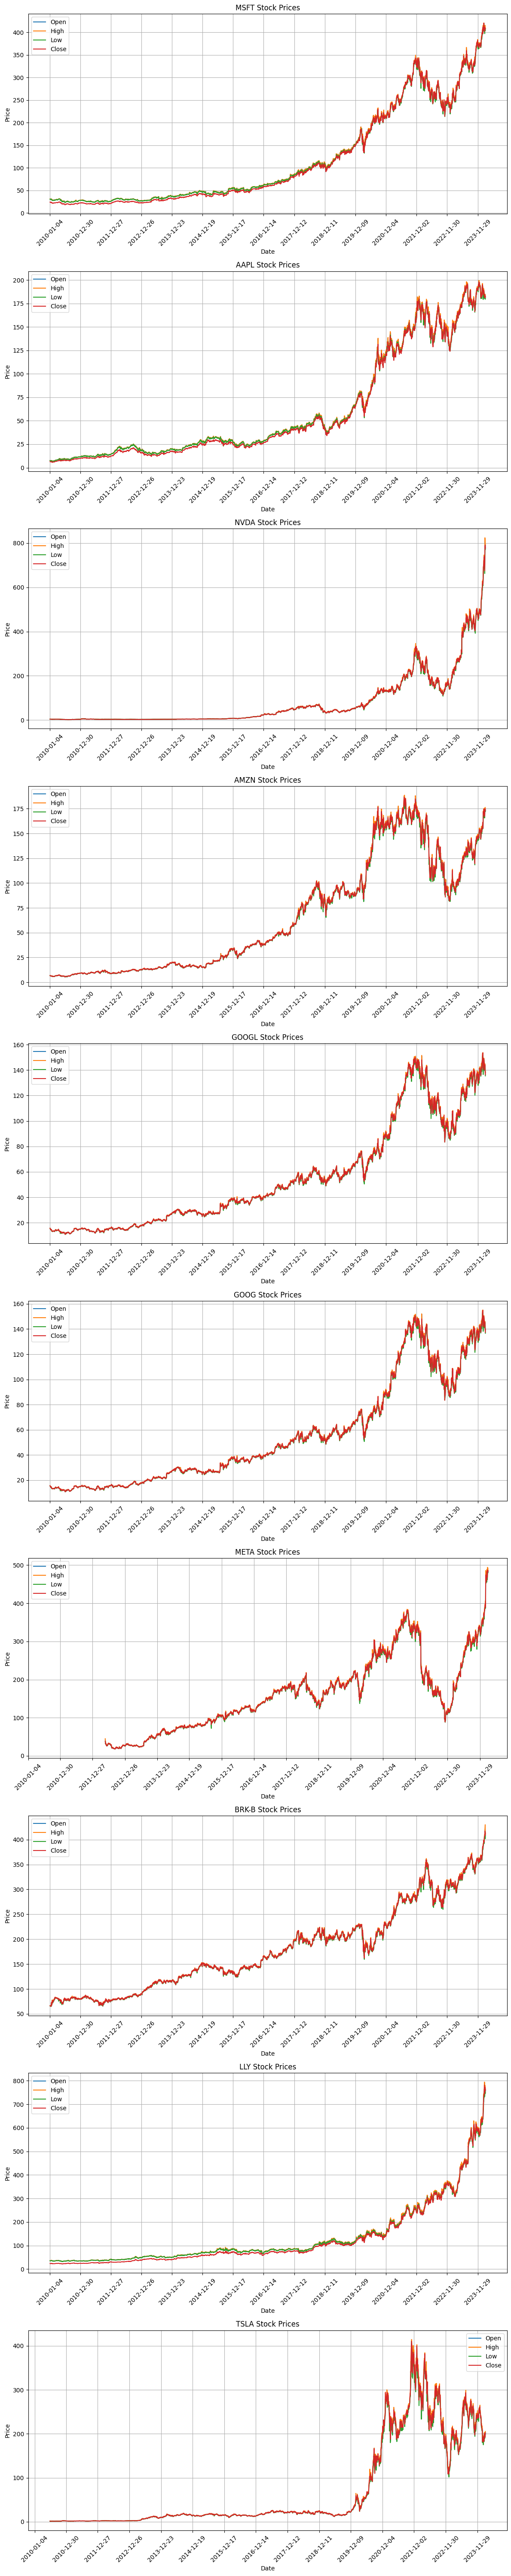

In [21]:
fig, axs = plt.subplots(len(top_10), 1, figsize=(12, 6*len(top_10)))

for ax, company in zip(axs, top_10):
    stock_data = stock[stock['Symbol'] == company]
    
    ax.plot(stock_data['Date'], stock_data['Open'], label='Open')
    ax.plot(stock_data['Date'], stock_data['High'], label='High')
    ax.plot(stock_data['Date'], stock_data['Low'], label='Low')
    ax.plot(stock_data['Date'], stock_data['Adj Close'], label='Close')
    
    ax.set_title(f'{company} Stock Prices')
    ax.set_xlabel("Date")
    ax.set_ylabel("Price")
    ax.set_xticks(stock_data['Date'][::250])
    ax.tick_params(axis='x', rotation=45)
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

#### Trump Data Analysis
Let's first start off with analyizing the amount of tweets Trump has over 2010 to 2021.

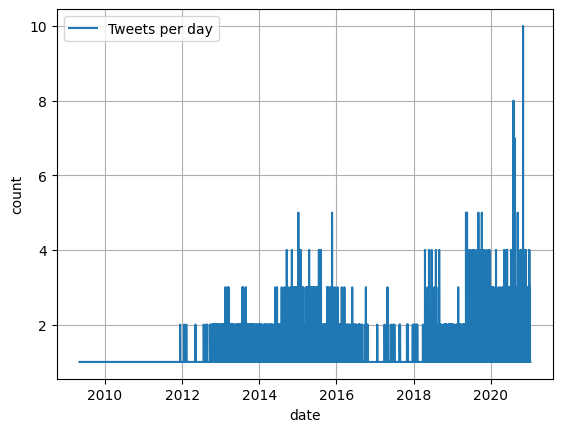

In [22]:
trump['date'] = pd.to_datetime(trump['date'])
tweets_per_day = trump['date'].value_counts().sort_index()
sns.lineplot(data=tweets_per_day, label='Tweets per day')
plt.grid()

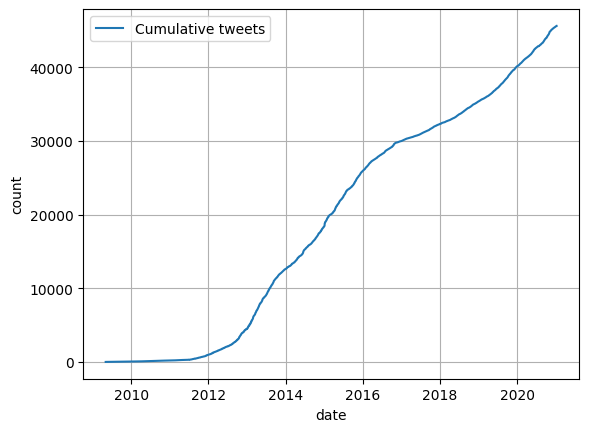

In [23]:
sum_tweets_per_day = tweets_per_day.cumsum()
sns.lineplot(data=sum_tweets_per_day, label='Cumulative tweets')
plt.grid()

We can see that the starting counts trend toward about 0 to 1 tweet per day, but over time have a trend towards increasing up to 2021. Some of the largest spikes in tweets came around the time of both the first and second election, and prior to when Trump was banned from Twitter.

Analyzing the favorites and retweets per day also shows a similar trend

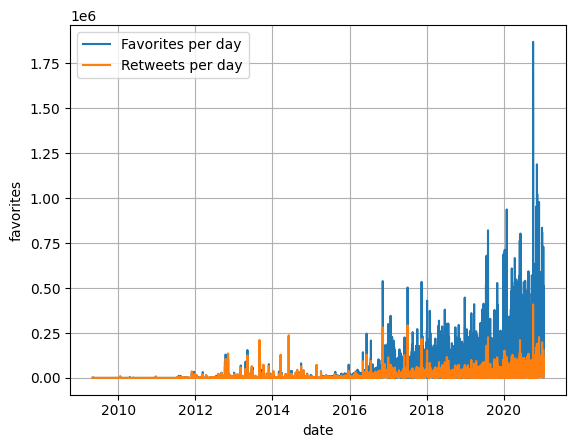

In [24]:
favorites_per_day = trump.groupby('date')['favorites'].sum()
retweets_per_day = trump.groupby('date')['retweets'].sum()
sns.lineplot(data=favorites_per_day, label='Favorites per day')
sns.lineplot(data=retweets_per_day, label='Retweets per day')
plt.grid()

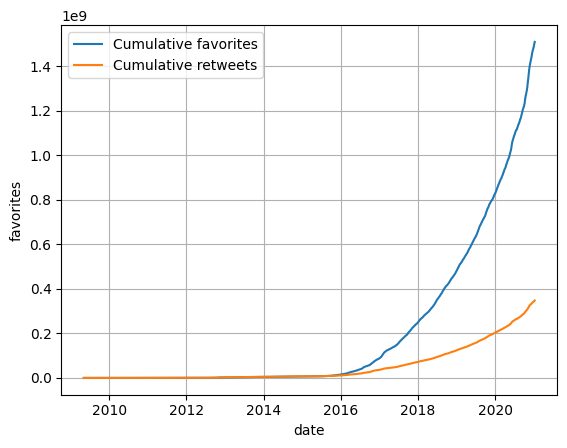

In [25]:
cum_favorites_per_day = favorites_per_day.cumsum()
cum_retweets_per_day = retweets_per_day.cumsum()
sns.lineplot(data=cum_favorites_per_day, label='Cumulative favorites')
sns.lineplot(data=cum_retweets_per_day, label='Cumulative retweets')
plt.grid()

For Sentiment Analysis, we used the Valence Aware Dictionary and sEntiment Reasoner (cjhutto), or VADER, model. We chose the VADER model because it has been tuned specifically for the sentiments of social media content. It is also a commonly used model for similar research (Kinyua J, et al.). To start, we must first compute the polarity of the tweets.

In [26]:
sia = SentimentIntensityAnalyzer()

def get_polarity(text):
    return sia.polarity_scores(text)['compound']

vectorized_get_polarity = np.vectorize(get_polarity)

trump['polarity'] = vectorized_get_polarity(trump['text'])

The polarity of the tweet gives us the emotional sentiment of the tweet. It is the only form of sentiment which VADER supports, however other models such as TextBlob support sentiments such as subjectivity (how opinionated is the sentiment), intent-based (what the user intends to do), and many others. We chose this particular form because it was the only one which VADER supports, but also it is one of the most commonly used metrics for tasks of a similar nature.
  
Once we have calculated the polarity, we can now create a new column which stores the cummulative polarity.

In [27]:
trump['polarityCumulative'] = trump['polarity'].cumsum()

The cummulative polarity will be what we use for trend analysis. When polarity is computed, the value is scored between -1 and 1. Negative one indicates a highly negative emotion tweet (tends to use words like bad, awful, etc.). Positive one indicates a highly positive emotion tweet (contains words like good, great, etc). This value is a continuous value between -1 and 1, so a cummulative calculation would mean that there is a chance the polarity could go up or down equally at any given point.

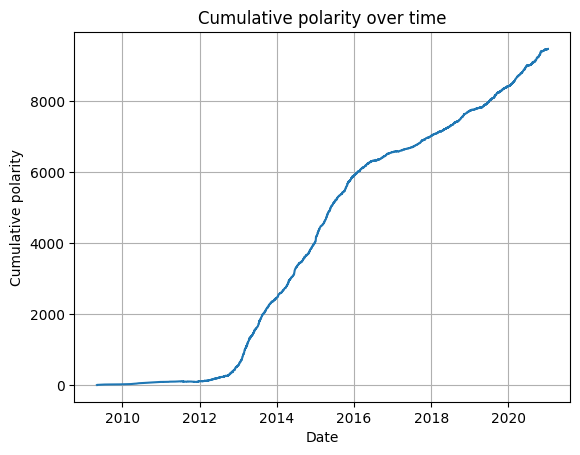

In [28]:
fig, ax = plt.subplots()
ax.plot(trump['date'], trump['polarityCumulative'])
ax.set(xlabel='Date', ylabel='Cumulative polarity',
       title='Cumulative polarity over time')
ax.grid()
plt.show()

Let's get an idea how much of the data is positive or negative. We're going to bin the polarity results based on the following criteria:
 - -1 to -0.6: Highly Negative
 - -0.6 to -0.2: Negative
 - -0.2 to 0.2: Neutral
 - 0.2 to 0.6: Positive
 - 0.6 to 1: Highly Positive

In [29]:
trump['polarityBinned'] = pd.cut(trump['polarity'], bins=[-1, -0.6, -0.2, 0.2, 0.6, 1], labels=['highly negative', 'negative', 'neutral', 'positive', 'highly positive'])

polarityBinned
highly positive    14296
neutral            10422
positive           10349
negative            5574
highly negative     4985
Name: count, dtype: int64


<Axes: ylabel='count'>

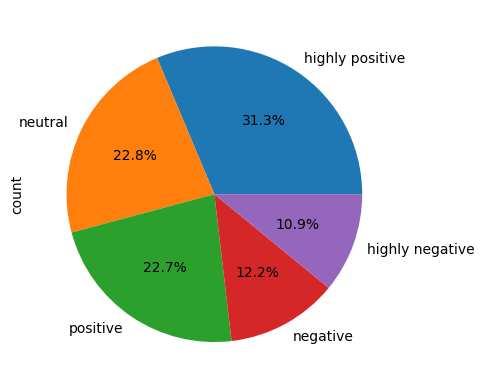

In [30]:
polarity_counts = trump['polarityBinned'].value_counts()
print(trump['polarityBinned'].value_counts())
polarity_counts.plot.pie(autopct='%1.1f%%')

Thanks to our data preprocessing earlier, we have a decently balanced pie chart of each polarity.  
Additionally, our choice in model made a large difference. Let's take a look at how this chart would look had we have used TextBlob, which is not specialized for social media sentiment analysis.

textBlobPolarityBinned
neutral            23056
positive           12448
highly positive     5747
negative            3429
highly negative      729
Name: count, dtype: int64


<Axes: ylabel='count'>

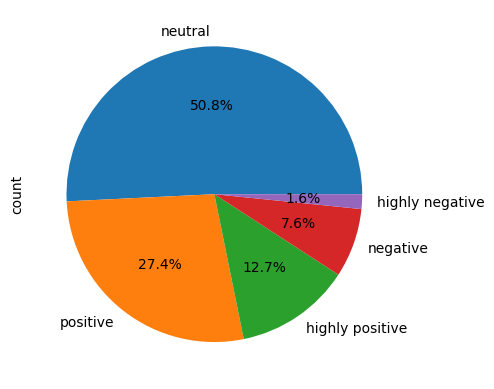

In [31]:
from textblob import TextBlob

def get_polarity(text):
    return TextBlob(text).sentiment.polarity

vectorized_get_polarity = np.vectorize(get_polarity)

trump['textBlobPolarity'] = vectorized_get_polarity(trump['text'])

trump['textBlobPolarityBinned'] = pd.cut(trump['textBlobPolarity'], bins=[-1, -0.6, -0.2, 0.2, 0.6, 1], labels=['highly negative', 'negative', 'neutral', 'positive', 'highly positive'])

polarity_counts = trump['textBlobPolarityBinned'].value_counts()
print(trump['textBlobPolarityBinned'].value_counts())
polarity_counts.plot.pie(autopct='%1.1f%%')

We can use TextBlob however to obtain the subjectivities, which we will use as an additional parameter to the linear regression prediction model, however we will not use it for correlation computation directly for a reason we will see shortly.

textBlobSubjectivityBinned
neutral              12560
subjective            9216
objective             5611
highly subjective     5148
very objective        3253
Name: count, dtype: int64


<Axes: ylabel='count'>

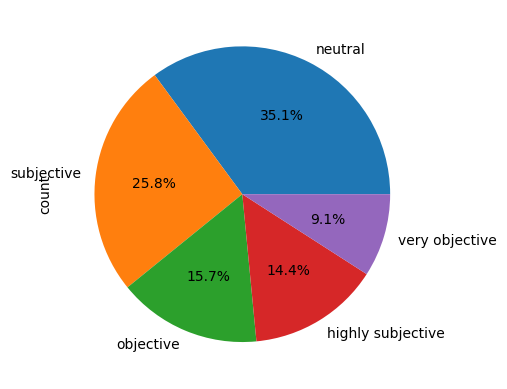

In [32]:
def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

vectorized_get_subjectivity = np.vectorize(get_subjectivity)

trump['textBlobSubjectivity'] = vectorized_get_subjectivity(trump['text'])

# Rescale for binning & trend accuracy
scaler = MinMaxScaler(feature_range=(-1, 1))
trump['textBlobSubjectivity'] = scaler.fit_transform(trump[['textBlobSubjectivity']])

trump['textBlobSubjectivityBinned'] = pd.cut(trump['textBlobSubjectivity'], bins=[-1, -0.6, -0.2, 0.2, 0.6, 1], labels=['very objective', 'objective', 'neutral', 'subjective', 'highly subjective'])

polarity_counts = trump['textBlobSubjectivityBinned'].value_counts()
print(trump['textBlobSubjectivityBinned'].value_counts())
polarity_counts.plot.pie(autopct='%1.1f%%')

The results of subjectivity are also quite well balanced, with a slight lean towards neutral. We can also see the trendline to see why we will not use it directly for correlation computation.

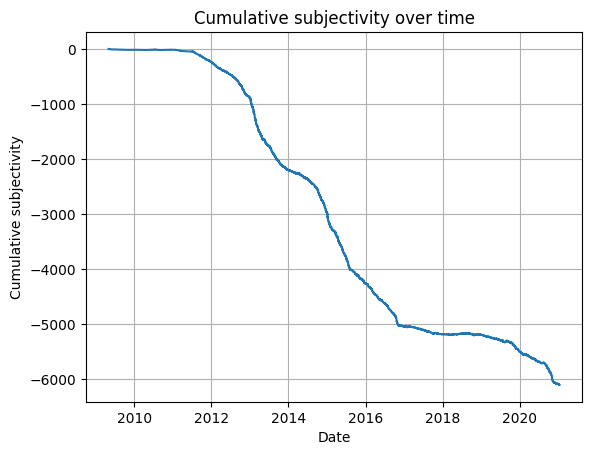

In [33]:
trump['subjectivityCumulative'] = trump['textBlobSubjectivity'].cumsum()

fig, ax = plt.subplots()
ax.plot(trump['date'], trump['subjectivityCumulative'])
ax.set(xlabel='Date', ylabel='Cumulative subjectivity',
       title='Cumulative subjectivity over time')
ax.grid()
plt.show()

This trend is a directly negative trend. While the values may be useful in the regression model to predict stock price fluctations, they will be less useful when computing correlations as no stock in the S&P 500 is on a consistent downward trend like this.

We can see that there is a much larger bias towards the neutral and positive categories, and the other ones don't even take up 25% of the pie chart. Using VADER will give us a more accurate and larger spread of results than TextBlob would.

We can also check out the spread of words with a word cloud, which will display a word larger if it is more frequently used.

In [34]:
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(trump['text'].str.cat())
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

AttributeError: 'ImageDraw' object has no attribute 'textbbox'

Of course, the word realDonaldTrump shows up most frequently, as this text is always included if someone tags him and he retweets it (which happens quite frequently).

We can also check out some word clouds at different polarity levels.

Below is a word cloud of all Neutral tweets

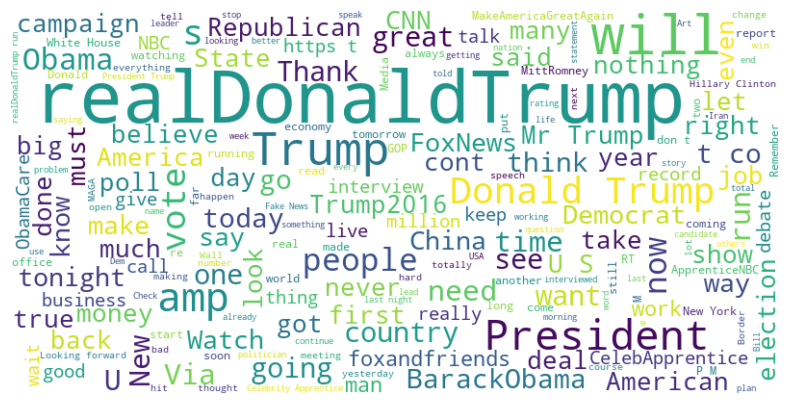

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(trump[trump['polarityBinned'].isin(['neutral'])]['text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Positive and highly positive tweets (in that order)

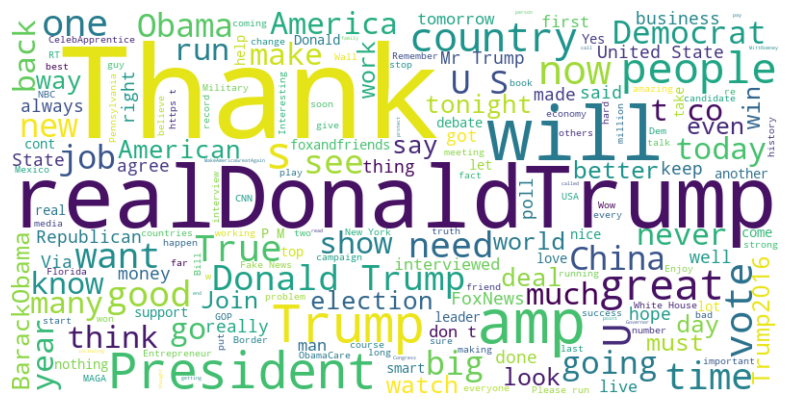

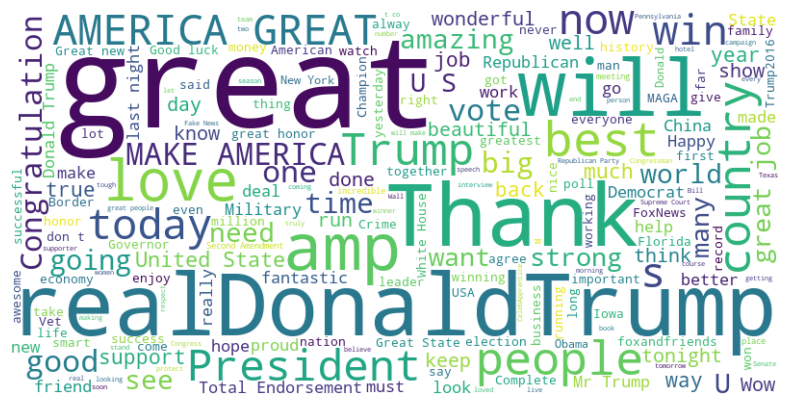

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(trump[trump['polarityBinned'].isin(['positive'])]['text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(trump[trump['polarityBinned'].isin(['highly positive'])]['text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Negative and highly negative (in that order)

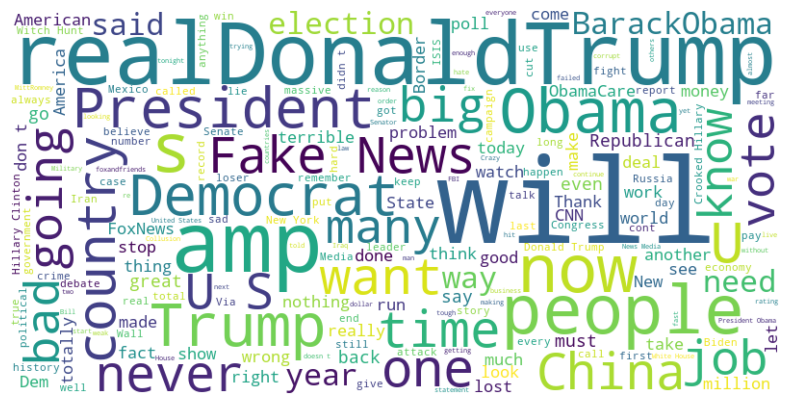

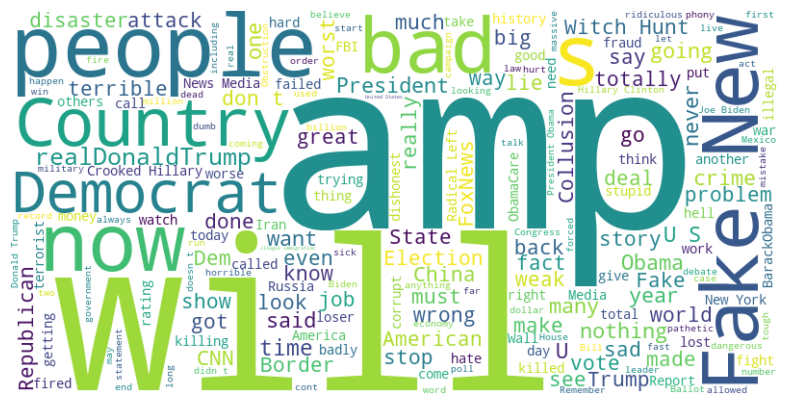

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(trump[trump['polarityBinned'].isin(['negative'])]['text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(' '.join(trump[trump['polarityBinned'].isin(['highly negative'])]['text']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Data Modelling and Prediction

#### Computing Correlations

Let's take a look at how we began to determine what stocks were most correlated with the sentiment of Donald Trump's tweets. We applied a few different techniques, and our end results give us the most correlated with the two different techniques we've chosen.  
  
The first technique is to compute the correlation of the cummulative sentiment trend to the different variables of the stocks over time. In order to achieve this, some additional post processing is necessary before we can compute a correlation. Let's check out the method we developed to compute this.

In [ ]:
def compute_correlation(company, stock_type, method):
    trump_2 = trump.copy()

    company_stock = stock[stock['Symbol'] == company]
    company_stock = company_stock[company_stock['Date'].between(trump['date'].min(), trump['date'].max())]

    stock_min = company_stock[company_stock['Symbol'] == company][stock_type].min()
    stock_max = company_stock[company_stock['Symbol'] == company][stock_type].max()

    scaler = MinMaxScaler(feature_range=(stock_min, stock_max))
    trump_2['polarityScaled'] = scaler.fit_transform(trump_2['polarityCumulative'].values.reshape(-1, 1))
    trump_2['polarityScaled'] = pd.to_numeric(trump_2['polarityScaled'])

    company_trump = trump_2[trump_2['date'].between(company_stock['Date'].min(), company_stock['Date'].max())]

    trump_dates = company_trump['date']
    stock_values = company_stock[['Date', stock_type]]
    missing_dates = trump_dates[~trump_dates.isin(stock_values['Date'])]
    stock_values = pd.concat([stock_values, pd.DataFrame({'Date': missing_dates, stock_type: np.nan})], ignore_index=True)
    stock_values = stock_values.sort_values('Date')
    stock_values = stock_values.reset_index(drop=True)
    stock_values[stock_type] = stock_values[stock_type].interpolate()
    stock_values = stock_values[stock_values['Date'].isin(trump_dates)]

    stock_values.dropna(inplace=True)
    company_trump = company_trump[company_trump['date'].between(stock_values['Date'].min(), stock_values['Date'].max())]
    transformed_polarity = company_trump['polarityScaled']
    transformed_adj_close = stock_values[stock_type]

    if len(transformed_polarity) == 0 or len(transformed_adj_close) == 0:
        return 0

    std_correlation = abs(transformed_polarity.corr(transformed_adj_close, method=method))

    return std_correlation

Let's break down this method:
1. The method requires the `company` symbol in the stock dataset, the `stock_type` we want to compare a trend against, and the `method` of correlation. For our case, we used Spearmans' correlation as it is a non-parametric test. A non-parametric test works best with our data as our data is not normally distributed. Spearmans does work better with ordinal data, however we did not find any issues with that assumption here.
2. We create a copy of the trump dataset, as we are later going to scale the values to match the stock data. 
```python
trump_2 = trump.copy()
```
3. We get all values in the stock dataset which match the company we chose earlier, and also keep only the stocks which are within the timeframe of the Trump data. This is because the stock data is up to date as of the start of the project, so many dates are too far in the future for what we have with the Trump data.
```python
company_stock = stock[stock['Symbol'] == company]
company_stock = company_stock[company_stock['Date'].between(trump['date'].min(), trump['date'].max())]
```
4. We get the minimum stock value for the chosen stock type, and the maximum. These will be used for the Min/Max scaling.
```python
stock_min = company_stock[company_stock['Symbol'] == company][stock_type].min()
stock_max = company_stock[company_stock['Symbol'] == company][stock_type].max()
```
5. Now we scale the cummulative polarity values to the range of the stock trend. This is necessary as the cummulative data is consistently far larger than the stock data in terms of trend accumulation, so scaling it provides a better chance for the correlation to exist.
```python
scaler = MinMaxScaler(feature_range=(stock_min, stock_max))
trump_2['polarityScaled'] = scaler.fit_transform(trump_2['polarityCumulative'].values.reshape(-1, 1))
trump_2['polarityScaled'] = pd.to_numeric(trump_2['polarityScaled'])
```
6. Now, as it is more important that the dates of the Trump data fit to the dates of the stocks, we trim the Trump data similar to the stock data before where we only keep dates which fall between the timeline of the stock we have. This is necessary as the stocks in the S&P 500 change in and out all the time, so a newer stock added doesn't have the same tracked data to before it was added.
```python
company_trump = trump_2[trump_2['date'].between(company_stock['Date'].min(), company_stock['Date'].max())]
```
7. Next, we have to do a little bit of filling in some empty data points. Because of how the stock data was collected, the stock changes only are logged at the end of the day. Mean the rows of data are only for one specific day. This means that if a tweet occurs in the middle of the day, there is no corresponding stock datapoint at that time. To fix this, we can linearly interpolate between the days of the stock, filling in the missing dates and times which do exist within the Trump data.
```python
trump_dates = company_trump['date']
stock_values = company_stock[['Date', stock_type]]
missing_dates = trump_dates[~trump_dates.isin(stock_values['Date'])]
stock_values = pd.concat([stock_values, pd.DataFrame({'Date': missing_dates, stock_type: np.nan})], ignore_index=True)
stock_values = stock_values.sort_values('Date')
stock_values = stock_values.reset_index(drop=True)
stock_values[stock_type] = stock_values[stock_type].interpolate()
stock_values = stock_values[stock_values['Date'].isin(trump_dates)]
```
> Note, performing this linear interpolation does not create serious deviations in the original stock data as shown below, the orange trend is the original values and the dotted blue trend is the intepolated values (complete overlap).

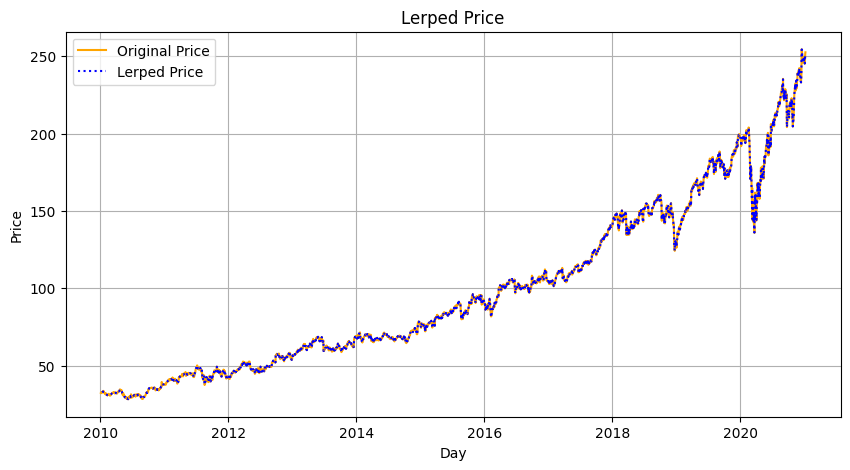

In [ ]:
method = "pearson"
stock_type = "Adj Close"
company = "ACN"

trump_2 = trump.copy()

company_stock = stock[stock['Symbol'] == company]
company_stock = company_stock[company_stock['Date'].between(trump['date'].min(), trump['date'].max())]

stock_min = company_stock[company_stock['Symbol'] == company][stock_type].min()
stock_max = company_stock[company_stock['Symbol'] == company][stock_type].max()

scaler = MinMaxScaler(feature_range=(stock_min, stock_max))
trump_2['polarityScaled'] = scaler.fit_transform(trump_2['polarityCumulative'].values.reshape(-1, 1))
trump_2['polarityScaled'] = pd.to_numeric(trump_2['polarityScaled'])

company_trump = trump_2[trump_2['date'].between(company_stock['Date'].min(), company_stock['Date'].max())]

trump_dates = company_trump['date']
stock_values = company_stock[['Date', stock_type]]
missing_dates = trump_dates[~trump_dates.isin(stock_values['Date'])]
stock_values = pd.concat([stock_values, pd.DataFrame({'Date': missing_dates, stock_type: np.nan})], ignore_index=True)
stock_values = stock_values.sort_values('Date')
stock_values = stock_values.reset_index(drop=True)
stock_values[stock_type] = stock_values[stock_type].interpolate()
stock_values = stock_values[stock_values['Date'].isin(trump_dates)]

plt.figure(figsize=(10, 5))
plt.plot(company_stock['Date'], company_stock["Adj Close"], label='Original Price', c="orange")
plt.plot(company_trump['date'], stock_values["Adj Close"], label='Lerped Price', linestyle='dotted', c="blue")
plt.title('Lerped Price')
plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

8. Then, we perform some final post-processing to ensure the dates line up correctly before a correlation is computed.
```python
stock_values.dropna(inplace=True)
company_trump = company_trump[company_trump['date'].between(stock_values['Date'].min(), stock_values['Date'].max())]
transformed_polarity = company_trump['polarityScaled']
transformed_adj_close = stock_values[stock_type]
```

9. Lastly, we can check if there is still data left (sometimes there is no overlap between the dates of a stock and the dates of the Trump tweets) and compute our chosen correlation and return it.
```python
if len(transformed_polarity) == 0 or len(transformed_adj_close) == 0:
    return 0

std_correlation = abs(transformed_polarity.corr(transformed_adj_close, method=method))
```

Now, let's use the method and get all the correlations.

In [ ]:
method = "spearman"
stock_types = ["Adj Close"]
correlations = {}
companies = stock['Symbol'].unique()
top_stock = {}

for stock_type in stock_types:
    for company in tqdm(companies):
        correlation = compute_correlation(company, stock_type, method)

        stock_and_type = company + " | " + stock_type

        correlations[stock_and_type] = correlation
        if top_stock == {} or correlation > list(top_stock.values())[0]:
            top_stock = {stock_and_type: correlation}

100%|██████████| 503/503 [01:48<00:00,  4.66it/s]


In [ ]:
correlations = pd.Series(correlations)
correlations = correlations.sort_values(ascending=False)
correlations.head(10)

DAY | Adj Close     0.899337
CTLT | Adj Close    0.854065
MRNA | Adj Close    0.850592
PAYC | Adj Close    0.847112
PYPL | Adj Close    0.825948
ETSY | Adj Close    0.796042
VTRS | Adj Close    0.791549
ALLE | Adj Close    0.773402
MCK | Adj Close     0.743165
HLT | Adj Close     0.735805
dtype: float64

Let's check out that top stock and see how it compares to the polarity trend.

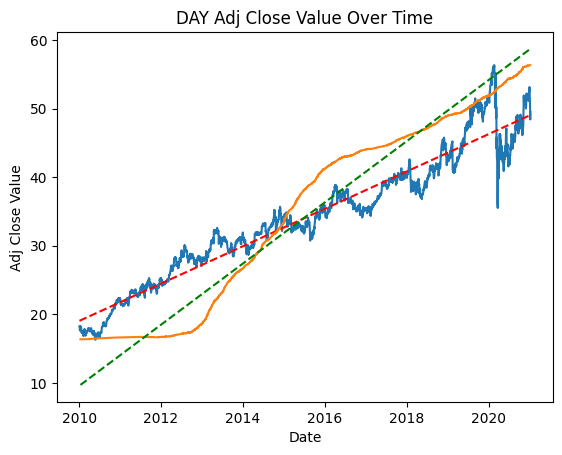

Correlation: 0.8993372390866515


In [ ]:
symbol, stock_type = list(top_stock.keys())[0].split(" | ")

trump_2 = trump.copy()

company_stock = stock[stock['Symbol'] == company]
company_stock = company_stock[company_stock['Date'].between(trump['date'].min(), trump['date'].max())]

stock_min = company_stock[company_stock['Symbol'] == company][stock_type].min()
stock_max = company_stock[company_stock['Symbol'] == company][stock_type].max()

scaler = MinMaxScaler(feature_range=(stock_min, stock_max))
trump_2['polarityScaled'] = scaler.fit_transform(trump_2['polarityCumulative'].values.reshape(-1, 1))
trump_2['polarityScaled'] = pd.to_numeric(trump_2['polarityScaled'])

company_trump = trump_2[trump_2['date'].between(company_stock['Date'].min(), company_stock['Date'].max())]

trump_dates = company_trump['date']
stock_values = company_stock[['Date', stock_type]]
missing_dates = trump_dates[~trump_dates.isin(stock_values['Date'])]
stock_values = pd.concat([stock_values, pd.DataFrame({'Date': missing_dates, stock_type: np.nan})], ignore_index=True)
stock_values = stock_values.sort_values('Date')
stock_values = stock_values.reset_index(drop=True)
stock_values[stock_type] = stock_values[stock_type].interpolate()
stock_values = stock_values[stock_values['Date'].isin(trump_dates)]

stock_values.dropna(inplace=True)
company_trump = company_trump[company_trump['date'].between(stock_values['Date'].min(), stock_values['Date'].max())]
transformed_polarity = company_trump['polarityScaled']
transformed_adj_close = stock_values[stock_type]


plt.plot(company_stock['Date'], company_stock[stock_type])
z = np.polyfit(mdates.date2num(company_stock['Date']), company_stock[stock_type], 1)
p = np.poly1d(z)
plt.plot(company_stock['Date'], p(mdates.date2num(company_stock['Date'])), "r--", label='Trend Line (Stock)')

plt.plot(company_trump['date'], company_trump['polarityScaled'])
z_polarity = np.polyfit(mdates.date2num(company_trump['date']), company_trump['polarityScaled'], 1)
p_polarity = np.poly1d(z_polarity)
plt.plot(company_trump['date'], p_polarity(mdates.date2num(company_trump['date'])), "g--", label='Trend Line (Polarity)')

plt.xlabel('Date')
plt.ylabel(stock_type + ' Value')
plt.title(symbol + ' ' + stock_type + ' Value Over Time')
plt.show()

std = compute_correlation(symbol, stock_type, method)

print("Correlation: " + str(std))

We can see that these two trends to seem to have a decent amount of correlation, the trend lines for each are very close to overlapping as well.

Let's now take a look at the second technique called "detrending". (Kenton, W.) This technique is commonly used in scientific, financial, sales, or marketing analysis to see the potential subtrends of data instead of the greater trend.

In [ ]:
def flatten_trend(x, y):
    x = mdates.date2num(x)
    slope, intercept, _, _, _ = linregress(x, y)
    trend_line = (slope * x) + intercept
    deviation = y - trend_line
    flat_average = np.mean(y)
    transformed_value = flat_average + deviation

    slope, intercept, _, _, _ = linregress(x, transformed_value)
    const_trend_line = (slope * x) + intercept
    transformed_value -= const_trend_line
    
    slope, intercept, _, _, _ = linregress(x, transformed_value)
    const_trend_line = (slope * x) + intercept
    
    return trend_line, transformed_value, const_trend_line

Looking at this method, we see it does this:
- Takes in an `x` and `y` parameter which are the x and y vectors we want to detrend. `x` always corresponds to the dates of the trend (reason we perform ` x = mdates.date2num(x)` to ensure it is a date format)
- We get the slope and y-intercept, and compute the trendline with these values.
```python
slope, intercept, _, _, _ = linregress(x, y)
trend_line = (slope * x) + intercept
```
- We calculate the deviation of each point from the trend line
```python
deviation = y - trend_line
```
- Next, we get the flattened average by taking the mean of the y vector
```
flat_average = np.mean(y)
```
- Then, we transform each deviation value by adding the average we just calculated
```
transformed_value = flat_average + deviation
```
- To reduce the transformed trend from being constant around the mean, we compute the trendline value and subtract it from each value
```python
slope, intercept, _, _, _ = linregress(x, transformed_value)
const_trend_line = (slope * x) + intercept
transformed_value -= const_trend_line
```
- Then, we recompute our trendline (now at y = 0) and return the original trendline, the transformed trend, and the constant trendline
```
slope, intercept, _, _, _ = linregress(x, transformed_value)
const_trend_line = (slope * x) + intercept
```

Using this transformation on our cummulative polarity trend, we get a new trend with a trendline of y = 0, successfully detrending the data.

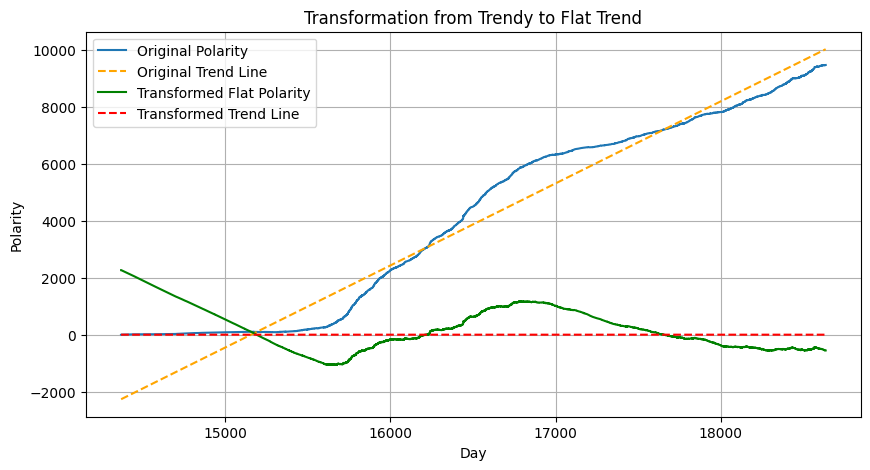

In [ ]:
x = mdates.date2num(trump['date'])
trend_line, transformed_polarity, const_trend_line = flatten_trend(trump['date'], trump['polarityCumulative'])

plt.figure(figsize=(10, 5))
plt.plot(x, trump['polarityCumulative'], label='Original Polarity')
plt.plot(x, trend_line, label='Original Trend Line', linestyle='--', color='orange')
plt.plot(x, transformed_polarity, label='Transformed Flat Polarity', color='green')
plt.plot(x, const_trend_line, label='Transformed Trend Line', linestyle='--', color='red')
plt.title('Transformation from Trendy to Flat Trend')

plt.xlabel('Day')
plt.ylabel('Polarity')
plt.legend()
plt.grid(True)
plt.show()

The same applies for any stock trend as well, regardless of parameter of stock chosen.

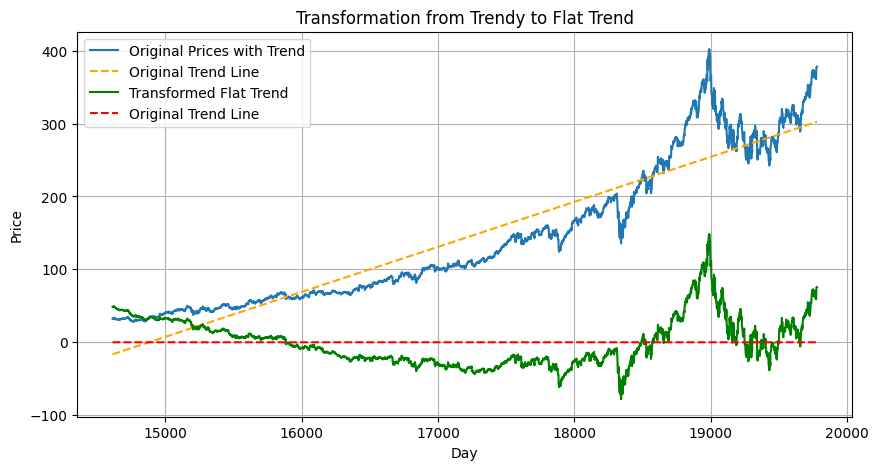

In [ ]:
company_stock = stock[stock['Symbol'] == "ACN"]
x = mdates.date2num(company_stock['Date'])

trend_line, transformed_polarity, const_trend_line = flatten_trend(company_stock['Date'], company_stock['Adj Close'])

plt.figure(figsize=(10, 5))
plt.plot(x, company_stock['Adj Close'], label='Original Prices with Trend')
plt.plot(x, trend_line, label='Original Trend Line', linestyle='--', color='orange')
plt.plot(x, transformed_polarity, label='Transformed Flat Trend', color='green')
plt.plot(x, const_trend_line, label='Original Trend Line', linestyle='--', color='red')
plt.title('Transformation from Trendy to Flat Trend')

plt.xlabel('Day')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

Fortunately, detrending the data adds barely any time as well to the computation, so let's modify the method from earlier to also return the detrended data, and recompute everything.

In [ ]:
def compute_correlation(company, stock_type, method):
    trump_2 = trump.copy()

    company_stock = stock[stock['Symbol'] == company]
    company_stock = company_stock[company_stock['Date'].between(trump['date'].min(), trump['date'].max())]

    stock_min = company_stock[company_stock['Symbol'] == company][stock_type].min()
    stock_max = company_stock[company_stock['Symbol'] == company][stock_type].max()

    scaler = MinMaxScaler(feature_range=(stock_min, stock_max))
    trump_2['polarityScaled'] = scaler.fit_transform(trump_2['polarityCumulative'].values.reshape(-1, 1))
    trump_2['polarityScaled'] = pd.to_numeric(trump_2['polarityScaled'])

    company_trump = trump_2[trump_2['date'].between(company_stock['Date'].min(), company_stock['Date'].max())]

    trump_dates = company_trump['date']
    stock_values = company_stock[['Date', stock_type]]
    missing_dates = trump_dates[~trump_dates.isin(stock_values['Date'])]
    stock_values = pd.concat([stock_values, pd.DataFrame({'Date': missing_dates, stock_type: np.nan})], ignore_index=True)
    stock_values = stock_values.sort_values('Date')
    stock_values = stock_values.reset_index(drop=True)
    stock_values[stock_type] = stock_values[stock_type].interpolate()
    stock_values = stock_values[stock_values['Date'].isin(trump_dates)]

    stock_values.dropna(inplace=True)
    company_trump = company_trump[company_trump['date'].between(stock_values['Date'].min(), stock_values['Date'].max())]
    transformed_polarity = company_trump['polarityScaled']
    transformed_adj_close = stock_values[stock_type]

    if len(transformed_polarity) == 0 or len(transformed_adj_close) == 0:
        return 0, 0

    std_correlation = abs(transformed_polarity.corr(transformed_adj_close, method=method))

    _, transformed_polarity, _ = flatten_trend(company_trump['date'], company_trump['polarityScaled'])
    _, transformed_adj_close, _ = flatten_trend(stock_values['Date'], stock_values[stock_type])

    trans_correlation = abs(transformed_polarity.corr(transformed_adj_close, method=method))

    return std_correlation, trans_correlation

The most major changes in our method now are:
```python
_, transformed_polarity, _ = flatten_trend(company_trump['date'], company_trump['polarityScaled'])
_, transformed_adj_close, _ = flatten_trend(stock_values['Date'], stock_values[stock_type])
```
which computes the detrend vectors for both polarity and the stock value chosen. We can then compute the correlation between these.

In [ ]:
method = "spearman"
stock_types = ["Adj Close", "Close", "High", "Low", "Open"]
correlations = {}
transformed_correlations = {}
companies = stock['Symbol'].unique()
top_stock = {}
top_trans_stock = {}

print("Total Correlations to Compute: " + str(len(companies) * len(stock_types)))

for stock_type in stock_types:
    print("Stock Type: " + stock_type)
    for company in tqdm(companies):
        correlation, transformed_correlation = compute_correlation(company, stock_type, method)

        stock_and_type = company + " | " + stock_type
        
        correlations[stock_and_type] = correlation
        transformed_correlations[stock_and_type] = transformed_correlation
        if top_stock == {} or correlation > list(top_stock.values())[0]:
            top_stock = {stock_and_type: correlation}
        if top_trans_stock == {} or transformed_correlation > list(top_trans_stock.values())[0]:
            top_trans_stock = {stock_and_type: transformed_correlation}

Total Correlations to Compute: 2515
Stock Type: Adj Close


100%|██████████| 503/503 [01:45<00:00,  4.75it/s]


Stock Type: Close


100%|██████████| 503/503 [01:45<00:00,  4.79it/s]


Stock Type: High


100%|██████████| 503/503 [01:47<00:00,  4.69it/s]


Stock Type: Low


100%|██████████| 503/503 [02:13<00:00,  3.76it/s]


Stock Type: Open


100%|██████████| 503/503 [02:40<00:00,  3.14it/s]


In [ ]:
correlations = pd.Series(correlations)
correlations = correlations.sort_values(ascending=False)
correlations.head(10)

DAY | Adj Close     0.899337
DAY | Close         0.899337
DAY | High          0.894158
DAY | Low           0.892045
DAY | Open          0.891850
CTLT | High         0.858258
CTLT | Open         0.854801
CTLT | Adj Close    0.854065
CTLT | Close        0.854065
MRNA | Adj Close    0.850592
dtype: float64

In [ ]:
transformed_correlations = pd.Series(transformed_correlations)
transformed_correlations = transformed_correlations.sort_values(ascending=False)
transformed_correlations.head(10)

FOXA | Close        0.880952
CTVA | High         0.880952
FOXA | Adj Close    0.833333
CTVA | Open         0.833333
UBER | High         0.809524
FOX | High          0.809524
CTVA | Adj Close    0.809524
FOX | Adj Close     0.809524
UBER | Open         0.809524
CTVA | Low          0.809524
dtype: float64

While we can see that the transformed trend did not identify a stronger correlation directly, lets look at those top trends for each technique and see the difference between them. The one with the lesser difference we can assume is more likely to be correlated.

In [ ]:
std_cor_diff = str(correlations[list(correlations.keys())[0]] - transformed_correlations[list(correlations.keys())[0]])
trans_cor_diff = str(transformed_correlations[list(transformed_correlations.keys())[0]] - correlations[list(transformed_correlations.keys())[0]])
min_diff = list(correlations.keys())[0] if std_cor_diff < trans_cor_diff else list(transformed_correlations.keys())[0]
print(list(correlations.keys())[0] + " correlation difference: " + std_cor_diff)
print(list(transformed_correlations.keys())[0] + " correlation difference: " + trans_cor_diff)
print("Minimum difference on: " + min_diff)

DAY | Adj Close correlation difference: 0.7806046537914572
FOXA | Close correlation difference: 0.2857142857142857
Minimum difference on: FOXA | Close


This shows us that FOXA has a lesser correlation difference between the trend correlation and the detrended correlation. We are going to then use FOXA for our predictive model. We can also view there trends below.

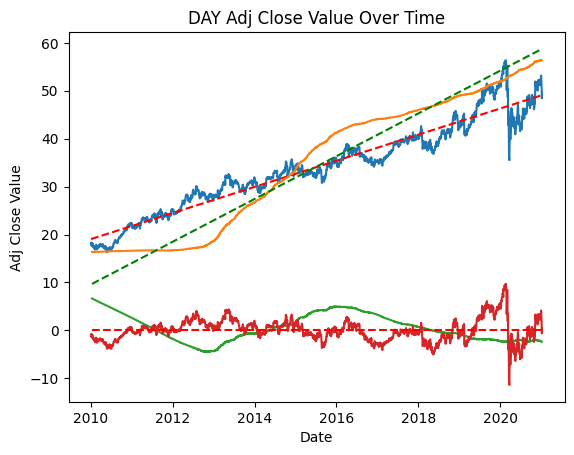

Correlation: 0.8993372390866515 | Transformed: 0.11873258529519437


In [ ]:
symbol = list(top_stock.keys())[0]
stock_type = symbol.split(" | ")[1]
symbol = symbol.split(" | ")[0]

trump_2 = trump.copy()

company_stock = stock[stock['Symbol'] == company]
company_stock = company_stock[company_stock['Date'].between(trump['date'].min(), trump['date'].max())]

stock_min = company_stock[company_stock['Symbol'] == company][stock_type].min()
stock_max = company_stock[company_stock['Symbol'] == company][stock_type].max()

scaler = MinMaxScaler(feature_range=(stock_min, stock_max))
trump_2['polarityScaled'] = scaler.fit_transform(trump_2['polarityCumulative'].values.reshape(-1, 1))
trump_2['polarityScaled'] = pd.to_numeric(trump_2['polarityScaled'])

company_trump = trump_2[trump_2['date'].between(company_stock['Date'].min(), company_stock['Date'].max())]

trump_dates = company_trump['date']
stock_values = company_stock[['Date', stock_type]]
missing_dates = trump_dates[~trump_dates.isin(stock_values['Date'])]
stock_values = pd.concat([stock_values, pd.DataFrame({'Date': missing_dates, stock_type: np.nan})], ignore_index=True)
stock_values = stock_values.sort_values('Date')
stock_values = stock_values.reset_index(drop=True)
stock_values[stock_type] = stock_values[stock_type].interpolate()
stock_values = stock_values[stock_values['Date'].isin(trump_dates)]

stock_values.dropna(inplace=True)
company_trump = company_trump[company_trump['date'].between(stock_values['Date'].min(), stock_values['Date'].max())]
transformed_polarity = company_trump['polarityScaled']
transformed_adj_close = stock_values[stock_type]


plt.plot(company_stock['Date'], company_stock[stock_type])
z = np.polyfit(mdates.date2num(company_stock['Date']), company_stock[stock_type], 1)
p = np.poly1d(z)
plt.plot(company_stock['Date'], p(mdates.date2num(company_stock['Date'])), "r--", label='Trend Line (Stock)')

plt.plot(company_trump['date'], company_trump['polarityScaled'])
z_polarity = np.polyfit(mdates.date2num(company_trump['date']), company_trump['polarityScaled'], 1)
p_polarity = np.poly1d(z_polarity)
plt.plot(company_trump['date'], p_polarity(mdates.date2num(company_trump['date'])), "g--", label='Trend Line (Polarity)')

# Plot the flattened trend
_, transformed_polarity, _ = flatten_trend(company_trump['date'], company_trump['polarityScaled'])
company_trump["transformedPolarityScaled"] = transformed_polarity
_, transformed_adj_close, _ = flatten_trend(company_stock['Date'], company_stock[stock_type])
company_stock["transformedAdjClose"] = transformed_adj_close

plt.plot(company_trump['date'], transformed_polarity)
plt.plot(company_stock['Date'], transformed_adj_close)
plt.hlines(y=0, xmin=stock_values["Date"].min(), xmax=stock_values["Date"].max(), color='r', linestyle='--')

plt.xlabel('Date')
plt.ylabel(stock_type + ' Value')
plt.title(symbol + ' ' + stock_type + ' Value Over Time')
plt.show()

std, trans = compute_correlation(symbol, stock_type, method)

print("Correlation: " + str(std) + " | Transformed: " + str(trans))

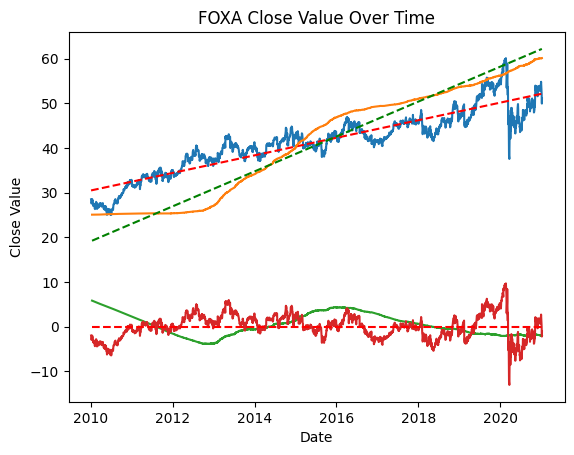

Correlation: 0.5952380952380953 | Transformed: 0.880952380952381


In [ ]:
symbol = list(top_trans_stock.keys())[0]
stock_type = symbol.split(" | ")[1]
symbol = symbol.split(" | ")[0]

trump_2 = trump.copy()

company_stock = stock[stock['Symbol'] == company]
company_stock = company_stock[company_stock['Date'].between(trump['date'].min(), trump['date'].max())]

stock_min = company_stock[company_stock['Symbol'] == company][stock_type].min()
stock_max = company_stock[company_stock['Symbol'] == company][stock_type].max()

scaler = MinMaxScaler(feature_range=(stock_min, stock_max))
trump_2['polarityScaled'] = scaler.fit_transform(trump_2['polarityCumulative'].values.reshape(-1, 1))
trump_2['polarityScaled'] = pd.to_numeric(trump_2['polarityScaled'])

company_trump = trump_2[trump_2['date'].between(company_stock['Date'].min(), company_stock['Date'].max())]

trump_dates = company_trump['date']
stock_values = company_stock[['Date', stock_type]]
missing_dates = trump_dates[~trump_dates.isin(stock_values['Date'])]
stock_values = pd.concat([stock_values, pd.DataFrame({'Date': missing_dates, stock_type: np.nan})], ignore_index=True)
stock_values = stock_values.sort_values('Date')
stock_values = stock_values.reset_index(drop=True)
stock_values[stock_type] = stock_values[stock_type].interpolate()
stock_values = stock_values[stock_values['Date'].isin(trump_dates)]

stock_values.dropna(inplace=True)
company_trump = company_trump[company_trump['date'].between(stock_values['Date'].min(), stock_values['Date'].max())]
transformed_polarity = company_trump['polarityScaled']
transformed_adj_close = stock_values[stock_type]


plt.plot(company_stock['Date'], company_stock[stock_type])
z = np.polyfit(mdates.date2num(company_stock['Date']), company_stock[stock_type], 1)
p = np.poly1d(z)
plt.plot(company_stock['Date'], p(mdates.date2num(company_stock['Date'])), "r--", label='Trend Line (Stock)')

plt.plot(company_trump['date'], company_trump['polarityScaled'])
z_polarity = np.polyfit(mdates.date2num(company_trump['date']), company_trump['polarityScaled'], 1)
p_polarity = np.poly1d(z_polarity)
plt.plot(company_trump['date'], p_polarity(mdates.date2num(company_trump['date'])), "g--", label='Trend Line (Polarity)')

# Plot the flattened trend
_, transformed_polarity, _ = flatten_trend(company_trump['date'], company_trump['polarityScaled'])
company_trump["transformedPolarityScaled"] = transformed_polarity
_, transformed_adj_close, _ = flatten_trend(company_stock['Date'], company_stock[stock_type])
company_stock["transformedAdjClose"] = transformed_adj_close

plt.plot(company_trump['date'], transformed_polarity)
plt.plot(company_stock['Date'], transformed_adj_close)
plt.hlines(y=0, xmin=stock_values["Date"].min(), xmax=stock_values["Date"].max(), color='r', linestyle='--')

plt.xlabel('Date')
plt.ylabel(stock_type + ' Value')
plt.title(symbol + ' ' + stock_type + ' Value Over Time')
plt.show()

std, trans = compute_correlation(symbol, stock_type, method)

print("Correlation: " + str(std) + " | Transformed: " + str(trans))

### Model

In [105]:
fox_data = stock[stock["Symbol"] == "FOXA"].dropna(axis=0)
fox_data["CloseDif"] = fox_data["Close"] - fox_data["Close"].shift(1, fill_value=0)
fox_data = fox_data[fox_data["CloseDif"] < 20]
fox_data["Date"] = pd.to_datetime(fox_data["Date"])
fox_data.head()

Date Symbol  Adj Close      Close       High        Low  \
732522 2019-03-13   FOXA  37.110039  39.750000  39.900002  38.700001   
732523 2019-03-14   FOXA  37.950264  40.650002  41.400002  39.750000   
732524 2019-03-15   FOXA  38.930534  41.700001  41.869999  41.240002   
732525 2019-03-18   FOXA  38.930534  41.700001  41.950001  41.049999   
732526 2019-03-19   FOXA  37.660854  40.340000  41.700001  39.840000   

             Open      Volume  CloseDif  
732522  39.000000  20477400.0  1.750000  
732523  39.750000   6248600.0  0.900002  
732524  41.380001   7107300.0  1.049999  
732525  41.950001   4020900.0  0.000000  
732526  41.549999  10118500.0 -1.360001

In [106]:
fox_data = fox_data.reset_index()

hold = pd.read_csv('trump_legacy/Trumps Legcy.csv')
hold["Date"] = pd.to_datetime(pd.to_datetime(hold["date"]).dt.date)

model_data = hold[hold["Date"].isin(set(fox_data["Date"]))]
model_data = model_data.reset_index()
model_data.shape

(13373, 8)

In [146]:
for i in model_data["Date"].unique():
    for t in model_data[model_data["Date"] == i].index:
        
        model_data.loc[model_data.index == t, "CloseDif"] = fox_data.loc[fox_data["Date"] == i,"CloseDif"].values
model_data['CloseDif'] = (model_data['CloseDif'] - model_data['CloseDif'].mean()) / model_data["CloseDif"].std()
model_data[["text", "Date", "CloseDif"]].head()

text       Date  CloseDif
0  I was thrilled to be back in the Great city of... 2020-03-03 -1.507538
1  RT @CBS_Herridge: READ: Letter to surveillance... 2020-01-17  0.325524
2  RT @MZHemingway: Very friendly telling of even... 2020-01-17  0.325524
3  RT @WhiteHouse: President @realDonaldTrump ann... 2020-01-17  0.325524
4                            https://t.co/4qwCKQOiOw 2020-10-23 -0.502746

#### Linear Regression

In [108]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import PredictionErrorDisplay, confusion_matrix, ConfusionMatrixDisplay

In [109]:
def get_subjectivity(text):
    return TextBlob(text).sentiment.polarity

vectorized_get_polarity = np.vectorize(get_subjectivity)

model_data['textBlobSubjectivity'] = vectorized_get_polarity(model_data['text'])

#trump['subjectivity'] = (trump['subjectivity'] - trump['subjectivity'].mean()) / trump["subjectivity"].std()

 
sia = SentimentIntensityAnalyzer()
 
def get_polarity(text):
    return sia.polarity_scores(text)['compound']
 
vectorized_get_polarity = np.vectorize(get_polarity)
 
model_data['polarity'] = vectorized_get_polarity(model_data['text'])
model_data.head()

index            id                                               text  \
0      1  1.234650e+18  I was thrilled to be back in the Great city of...   
1      2  1.218010e+18  RT @CBS_Herridge: READ: Letter to surveillance...   
2      4  1.218160e+18  RT @MZHemingway: Very friendly telling of even...   
3      5  1.217960e+18  RT @WhiteHouse: President @realDonaldTrump ann...   
4      7  1.319500e+18                            https://t.co/4qwCKQOiOw   

               device  favorites  retweets             date       Date  \
0  Twitter for iPhone      73748     17404    3/3/2020 1:34 2020-03-03   
1  Twitter for iPhone          0      7396   1/17/2020 3:22 2020-01-17   
2  Twitter for iPhone          0      9081  1/17/2020 13:13 2020-01-17   
3  Twitter for iPhone          0     25048   1/17/2020 0:11 2020-01-17   
4  Twitter for iPhone     130822     19127  10/23/2020 4:52 2020-10-23   

   CloseDif  textBlobSubjectivity  polarity  
0 -1.507538              0.458929    0.9792  
1  0.325524              0.050000    0.0000  
2  0.325524              0.268750    0.5413  
3  0.325524              0.095238    0.6360  
4 -0.502746              0.000000    0.0000

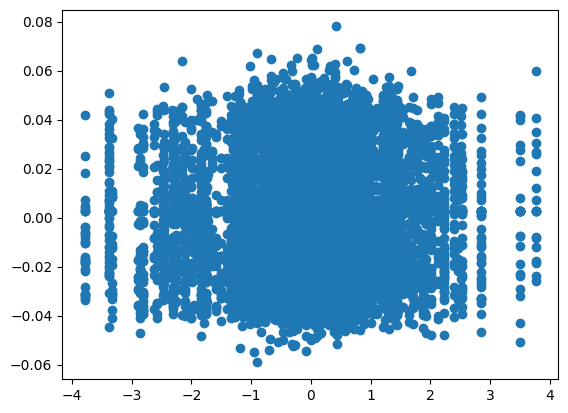

In [110]:


test_model = LinearRegression().fit(model_data[["polarity", "textBlobSubjectivity"]], model_data["CloseDif"])
model_data["regressionPredictions"] = test_model.predict(model_data[["polarity", "textBlobSubjectivity"]])



In [ ]:
fig, ax = plt.subplots()
ax.scatter(model_data["CloseDif"], model_data["regressionPredictions"])

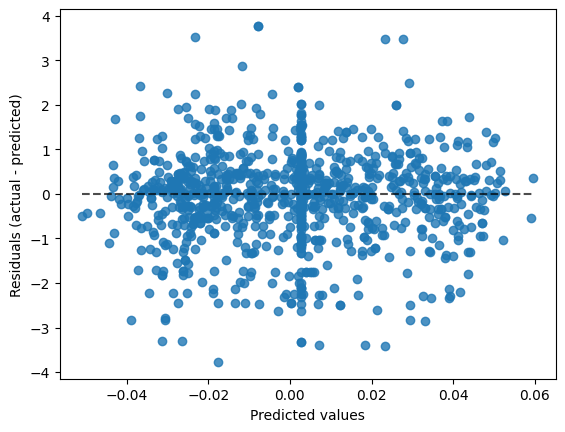

In [111]:
PredictionErrorDisplay.from_estimator(test_model, model_data[["polarity", "textBlobSubjectivity"]], model_data["CloseDif"])

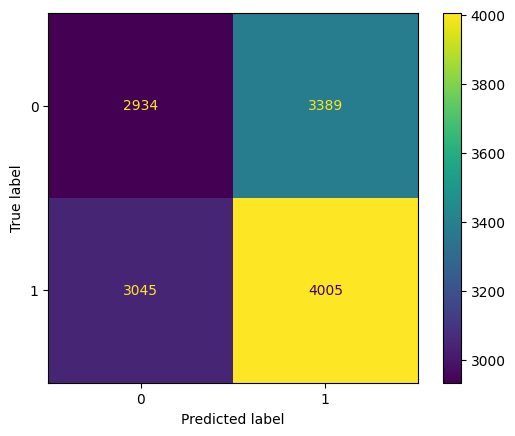

In [148]:
predictions = model_data["regressionPredictions"].values
y_actual = model_data["CloseDif"].values / abs(model_data["CloseDif"].values)
y_predicted = (predictions / abs(predictions))
matrix = confusion_matrix(y_actual, y_predicted)
#ever so slightly better then just doing random odds
disp = ConfusionMatrixDisplay(matrix)
disp.plot()
plt.show()

In [149]:
print((matrix[0,0] + matrix[1,1]) / matrix.sum())
print(matrix[1,1] / (matrix[1,1] + matrix[0,1]))

0.5188813280490541
0.5416553962672437


#### Bert Transformer into neural network

In [114]:
import os
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub

from official.nlp import optimization 
os.environ["TFHUB_CACHE_DIR"] = "tmp"


In [115]:
model_data.shape

(13373, 12)

In [116]:


dataset = tf.data.Dataset.from_tensor_slices((model_data['text'].values, model_data['CloseDif'].values))

val = int(0.1 * model_data.shape[0])
train = int(0.9 * model_data.shape[0])


dataset = dataset.shuffle(model_data.shape[0])

val_set = dataset.take(val)
train_set = dataset.skip(val)

train_set = train_set.batch(batch_size=32)
val_set = val_set.batch(batch_size=32)
len(train_set)

377

In [117]:
#Make sure to delete the stuff this downloads changing the cache directory prevents auto deletion
preproccess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
bert_preprocess_model = hub.KerasLayer(preproccess)

In [118]:
text_test = ['Sleepy joe is my best friend']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [  101 17056  3533  2003  2026  2190  2767   102     0     0     0     0]
Input Mask : [1 1 1 1 1 1 1 1 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [119]:
bert = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
bert_model = hub.KerasLayer(bert)

In [120]:
def build_regression_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(preproccess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(bert, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(8, activation="selu")(net)
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='regressor')(net)
  return tf.keras.Model(text_input, net)

In [121]:
regressor_model = build_regression_model()
bert_raw_result = regressor_model(tf.constant(text_test))
print(bert_raw_result)

tf.Tensor([[1.3908193]], shape=(1, 1), dtype=float32)


In [137]:
loss = tf.keras.losses.MeanSquaredError()
metrics = tf.metrics.RootMeanSquaredError()

epochs = 4
steps_per_epoch = tf.data.experimental.cardinality(dataset).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

regressor_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [138]:
history = regressor_model.fit(x=train_set,
                               validation_data=val_set,
                               epochs=epochs)

Epoch 1/4


377/377 [==============================] - 172s 449ms/step - loss: 1.2264 - root_mean_squared_error: 1.1074 - val_loss: 0.9353 - val_root_mean_squared_error: 0.9671
Epoch 2/4
377/377 [==============================] - 170s 452ms/step - loss: 1.2330 - root_mean_squared_error: 1.1104 - val_loss: 0.8979 - val_root_mean_squared_error: 0.9476
Epoch 3/4
377/377 [==============================] - 169s 447ms/step - loss: 1.1928 - root_mean_squared_error: 1.0922 - val_loss: 1.0008 - val_root_mean_squared_error: 1.0004
Epoch 4/4
377/377 [==============================] - 169s 448ms/step - loss: 1.1761 - root_mean_squared_error: 1.0845 - val_loss: 0.9527 - val_root_mean_squared_error: 0.9761


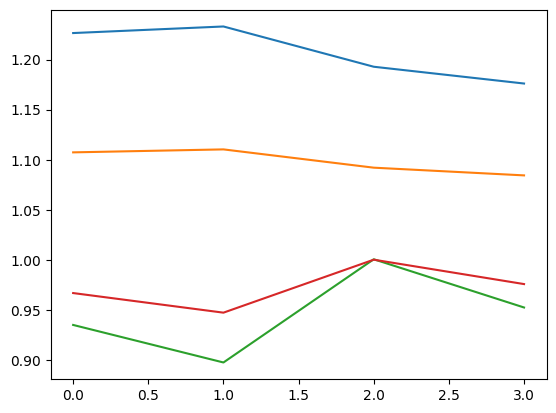

In [140]:
fig, ax = plt.subplots()

plt.plot(history.history["loss"])
plt.plot(history.history["root_mean_squared_error"])
plt.plot(history.history["val_loss"])
plt.plot(history.history["val_root_mean_squared_error"])

In [141]:
model_data["transformerPredictions"] = regressor_model.predict(x = model_data["text"].values)

418/418 [==============================] - 54s 129ms/step


Text(0, 0.5, 'Predicted')

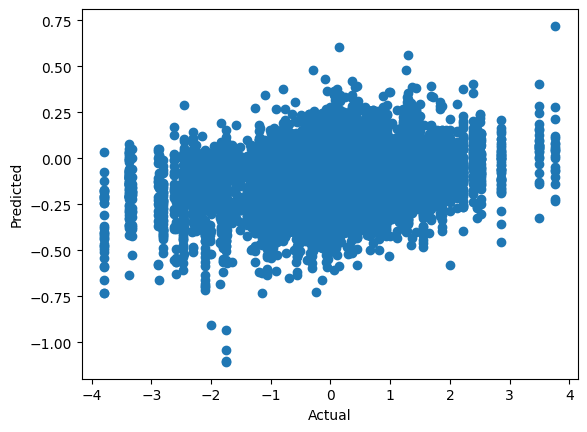

In [142]:
fig, ax = plt.subplots()

ax.scatter(model_data["CloseDif"], model_data["transformerPredictions"])
plt.xlabel("Actual")
plt.ylabel("Predicted")

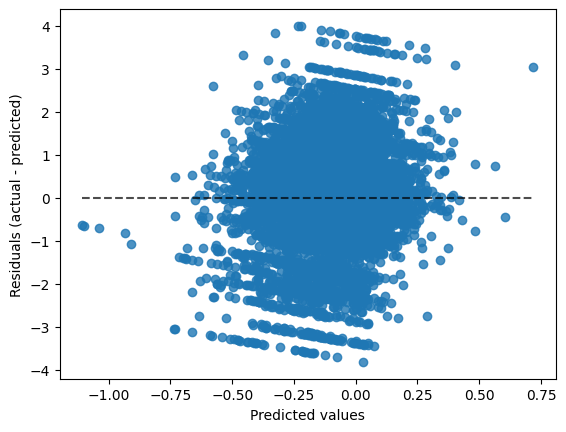

In [143]:
disp = PredictionErrorDisplay(y_true = model_data["CloseDif"], y_pred = model_data["transformerPredictions"])
disp.plot()

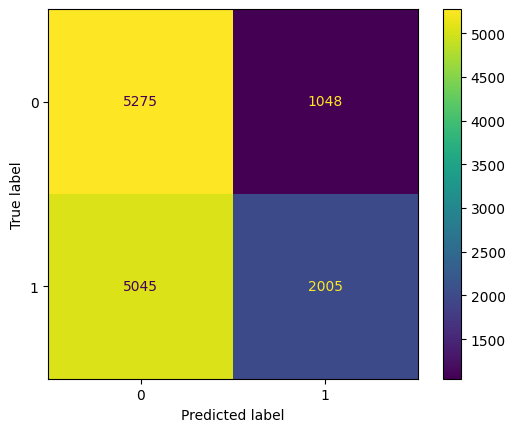

In [144]:
predictions = model_data["transformerPredictions"].values
y_actual = model_data["CloseDif"].values / abs(model_data["CloseDif"].values)
y_predicted = (predictions / abs(predictions))
matrix = confusion_matrix(y_actual, y_predicted)
#ever so slightly better then just doing random odds
disp = ConfusionMatrixDisplay(matrix)
disp.plot()
plt.show()

In [145]:
print((matrix[0,0] + matrix[1,1]) / matrix.sum())
print(matrix[1,1] / (matrix[1,1] + matrix[0,1]))

0.5443804681073805
0.6567310841794956


### Citations

1. cjhutto. (2018, December 19). cjhutto/vaderSentiment. GitHub. https://github.com/cjhutto/vaderSentiment
2. Kenton, W. (n.d.). Detrend. Investopedia. https://www.investopedia.com/terms/d/detrend.asp
3. Kinyua, J. D., Mutigwe, C., Cushing, D. J., & Poggi, M. (2021). An analysis of the impact of President Trump’s tweets on the DJIA and S&P 500 using machine learning and sentiment analysis. Journal of Behavioral and Experimental Finance, 29, 100447. https://doi.org/10.1016/j.jbef.2020.100447